<a href="https://colab.research.google.com/github/AishaEvering/PyTorch_Exercises/blob/main/09_pytorch_model_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

## Resorces:

* Book version of notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/
* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf

## 0. Get setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 25.68 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30 FPS+ or 30 ms latency)
  * Latency = time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)


## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch = https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html



In [6]:
# 1. Setup pretrained EffNetB2 weights
effnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnet_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnet_weights) # could also use weights=DEFAULT

#4. Freeze base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 85.2MB/s]


In [7]:

from torchinfo import summary

# Print EffNetB2 summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
# Set seeds for reporducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [10]:
# Print EffNetB2 summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [74]:
def create_effnetb2_model(num_classes:int=3,  # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42) -> tuple[torchvision.models.efficientnet.EfficientNet, torchvision.transforms.Compose]:

  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  #4. Freeze base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )

  return model, transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

In [13]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
# Print EffNetB2 summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 3.2 Creating DataLoaders for EffNetB2

In [15]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [16]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

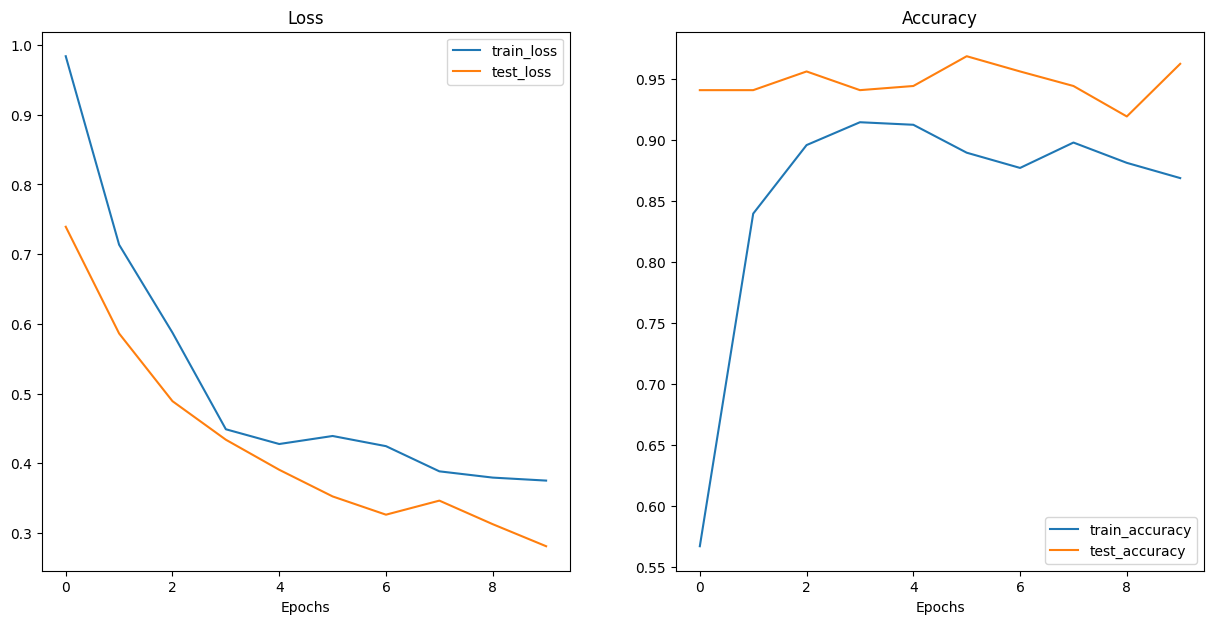

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [19]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [20]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [21]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
f'{effnetb2_total_params:_}'

'7_705_221'

In [22]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results['test_loss'][-1],
                  "test_acc": effnetb2_results['test_acc'][-1],
                  "total_params": effnetb2_total_params,
                  "total_params_formatted": f'{effnetb2_total_params:_}',
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'total_params': 7705221,
 'total_params_formatted': '7_705_221',
 'model_size (MB)': 29.8638858795166}

## 4.0 Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor.

In [23]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [24]:
def create_vit_model(num_classes:int=3,
                     seed:int=42) -> tuple[torchvision.models.efficientnet.EfficientNet, torchvision.transforms.Compose]:
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))

  return model, transforms

In [25]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 160MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [26]:
# Print ViT summary
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [27]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extractor

We're up to model experiment 2: a ViT Feature Extractor.

In [28]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Training function
set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

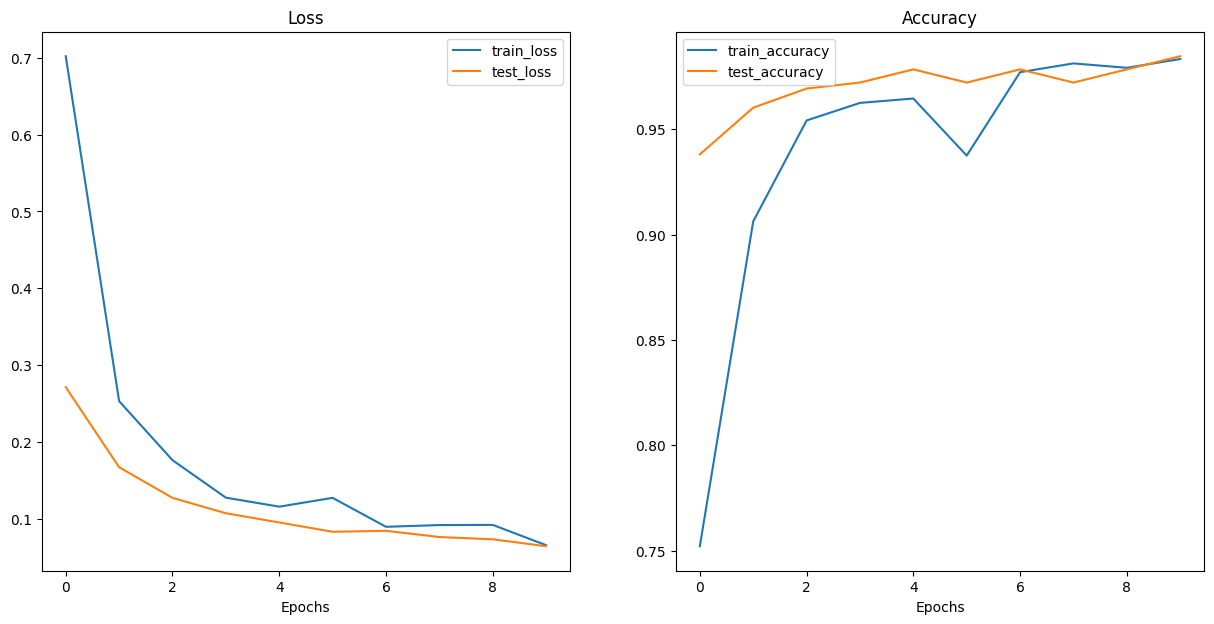

In [29]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [30]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [31]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {round(pretrained_vit_model_size, 2)} MB")

Pretrained ViT feature extractor model size: 327.37 MB


### 4.6 Collecting ViT feature extractor stats

In [32]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
f'{vit_total_params:_}'

'85_800_963'

In [33]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss": vit_results['test_loss'][-1],
                  "test_acc": vit_results['test_acc'][-1],
                  "total_params": vit_total_params,
                  "total_params_formatted": f'{vit_total_params:_}',
                  "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'total_params': 85800963,
 'total_params_formatted': '85_800_963',
 'model_size (MB)': 327.37096977233887}

### 5. Making predictions with our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+ FPS)

To test criteria 2:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let's work towards makeing a function called `pred_and_store()` to do so.


Firt we'll need a list of test image paths.

In [34]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/389730.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2012780.jpg')]

### 5.1 Creating a funciton to make predictions across test dataset

Steps to create `pred_and_score()`:
1. Create a function that takes...
  * a list of paths
  * a trained PyTorch model
  * a series of transforms
  * a list of target class names
  * a target device
2. Create an empty list (can return a full list of all predictions later)
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (predication statistics will go in here)
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn no `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass -> calculate pred prob -> pred class.
11. Add the pred prob and pred class to empty dictionary from  step 4
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [35]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm



def pred_and_store(paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: list[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> list[dict]:
  pred_list = []

  for path in tqdm(paths):
    # start the time!
    start_time = timer()

    pred_dict, transformed_image = preprocess_img(path, transform, device)

    pred_prob, pred_class = make_prediction(model, transformed_image, class_names, device)

    pred_dict['pred_prob'] =  pred_prob
    pred_dict['pred_class'] = pred_class

    # stop the timer!
    end_time = timer()

    pred_dict['time_for_pred'] = round(end_time - start_time, 4)

    pred_dict['correct'] = pred_dict['class_name'] == pred_class

    pred_list.append(pred_dict)

  return pred_list


def preprocess_img(path: pathlib.Path, transform: torchvision.transforms, device: str) -> tuple[dict, torch.Tensor]:
  pred_dict = {}

  pred_dict['image_path'] = path
  pred_dict['class_name'] = path.parent.stem # name of the parent folder

  # open the image
  img = Image.open(path)

  # transform image
  transformed_image = transform(img).unsqueeze(0).to(device) # transform, add batch dimension, put it on target device

  return pred_dict, transformed_image

def make_prediction(model: torch.nn.Module,
                    transformed_image,
                    class_names: list[str],
                    device: str) -> tuple[float, str]:

  model = model.to(device)

  model.eval() # prepare model for inference

  with torch.inference_mode():
    pred_logit = model(transformed_image)
    pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediciton probablities
    pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probablity into index of prediction label
    pred_class = class_names[pred_label.cpu()] # NOTE: python variables live on the cpu

  return round(pred_prob.unsqueeze(0).max().cpu().item(), 4), pred_class

### 5.2 Making a timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

2 things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model)
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)

In [36]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device='cpu') # hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/389730.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6722,
  'pred_class': 'sushi',
  'time_for_pred': 0.2194,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6704,
  'pred_class': 'sushi',
  'time_for_pred': 0.1577,
  'correct': True}]

In [38]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd

effneb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effneb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.6722,sushi,0.2194,True
1,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.6704,sushi,0.1577,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9516,sushi,0.1323,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9171,sushi,0.1439,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.8724,sushi,0.1354,True


In [39]:
# Check number of correct predictions
effneb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [40]:
# Find the average time per predictions
goal_time = 0.03
effnetb2_avg_time_per_pred = round(effneb2_test_pred_df.time_for_pred.mean(), 4)

if effnetb2_avg_time_per_pred > goal_time:
  app_text = f'off by {round(effnetb2_avg_time_per_pred - goal_time, 4)}'
else:
  app_text = f'fast or faster by {round(goal_time - effnetb2_avg_time_per_pred, 4)}'

print(f'EffNetB2 average time per prediction: {effnetb2_avg_time_per_pred} {app_text}')

EffNetB2 average time per prediction: 0.1044 off by 0.0744


**Note:** Prediction times will vary (much like training times) depending on the hardware you're using... so generally the faster you compute (e.g. CPU or GPU), the faster the predictions will happen.

In [41]:
# Add average time per prediction to ViT stats
effnetb2_stats['time_per_pred_cpu'] = effnetb2_avg_time_per_pred
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'total_params': 7705221,
 'total_params_formatted': '7_705_221',
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1044}

### 5.3 Making and timing predictions and with ViT

In [42]:
# Make predictions across test dataset with ViT
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device='cpu') # hardcode predictions to happen on CPU, not sure GPU available when we deploy

  0%|          | 0/150 [00:00<?, ?it/s]

In [43]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/389730.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.991,
  'pred_class': 'sushi',
  'time_for_pred': 0.5422,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.848,
  'pred_class': 'sushi',
  'time_for_pred': 0.4273,
  'correct': True}]

In [44]:
# Turn vi_test_pred_dicts
import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9910,sushi,0.5422,True
1,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.8480,sushi,0.4273,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9903,sushi,0.4144,True
3,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9963,sushi,0.3973,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9672,sushi,0.4090,True


In [45]:
# See how many correct
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [46]:
# Find the average time per predictions
goal_time = 0.03
vit_avg_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)

if vit_avg_time_per_pred > goal_time:
  app_text = f'off by {round(vit_avg_time_per_pred - goal_time, 4)}'
else:
  app_text = f'fast or faster by {round(goal_time - vit_avg_time_per_pred, 4)}'

print(f'ViT average time per prediction: {vit_avg_time_per_pred} {app_text}')

ViT average time per prediction: 0.4437 off by 0.4137


In [47]:
# Add average time per prediction to ViT stats
vit_stats['time_per_pred_cpu'] = vit_avg_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'total_params': 85800963,
 'total_params_formatted': '85_800_963',
 'model_size (MB)': 327.37096977233887,
 'time_per_pred_cpu': 0.4437}

## 6. Comparing model results, prediction times and size

In [48]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages
df['test_acc'] = round(df['test_acc'] * 100, 2)
df.head()

,test_loss,test_acc,total_params,total_params_formatted,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,7_705_221,29.863886,0.1044,EffNetB2
1,0.064435,98.47,85800963,85_800_963,327.370970,0.4437,ViT


Which model is better?
* `test_loss` (lower is better): ViT
* `test_acc` (higher is better): ViT
* `number_of_parameters` (generally lower is better*) - (if a model has more parameters, it generally takes longer to compute): EffNetB2
  * *sometimes models with higher parameters can still perform fast*
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2


Both models fail to achieve our goal of 30+ FPS... however we could always just try and use EffNetB2 and see how it goes.

In [49]:
df.set_index('model').loc['ViT'].drop('total_params_formatted')
#.drop('total_params_formatted', axis=1)

test_loss             0.064435
test_acc                 98.47
total_params          85800963
model_size (MB)      327.37097
time_per_pred_cpu       0.4437
Name: ViT, dtype: object

In [50]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index('model').loc['ViT'].drop('total_params_formatted') / df.set_index('model').loc['EffNetB2'].drop('total_params_formatted')), columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,total_params,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,10.962102,4.25


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend base on the model sized (model_size (MB)).

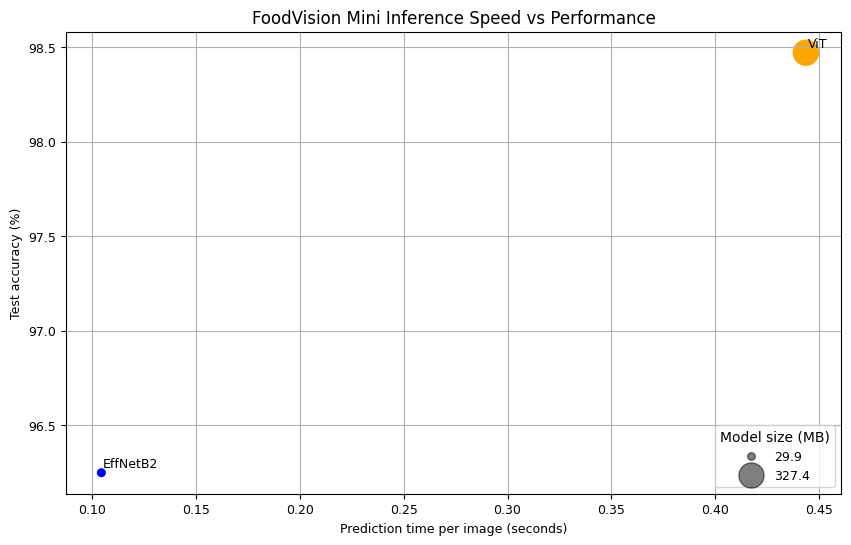

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(data=df,
                     x='time_per_pred_cpu',
                     y='test_acc',
                     c=['blue', 'orange'],
                     s='model_size (MB)')

ax.set_title('FoodVision Mini Inference Speed vs Performance', fontsize=12)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=9)
ax.set_ylabel('Test accuracy (%)', fontsize=9)
ax.tick_params(axis='both', labelsize=9)
ax.grid(True)

for index, row in df.iterrows():
  ax.annotate(text=row['model'],
              xy=(row['time_per_pred_cpu']+0.0008, row['test_acc']+0.03),
              size=9)

handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)

model_size_legend = ax.legend(handles,
                              labels,
                              loc='lower right',
                              title="Model size (MB)",
                              fontsize=9)

plt.savefig('09-foodvision-mini-inference-speed-vs-performance.png')

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it meets our criteria the best.

What is Gradio?
> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! https://www.gradio.app/





In [52]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.1 MB

### 7.1 Gradio overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradio is to map inputes -> function/model -> outputs

### 7.2 Creating a function to map our inputs and outputs

In [53]:
# Put our model on the CPU
effnetb2 = effnetb2.to('cpu')

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs(food class label, prediction time)
```

In [54]:
def predict(img) -> tuple[dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)


  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [55]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

# Radomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)

print(f'[INFO] Predicting on image at path: {random_image_path}\n')

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)

print(pred_dict, pred_time, sep='\n')

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/3834718.jpg

{'pizza': 0.23051390051841736, 'steak': 0.04953045770525932, 'sushi': 0.7199556827545166}
0.1733


### 7.3 Creating a list of example image

The example for Gradio can be created with the `examples` parameter, see here: https://www.gradio.app/guides/quickstart#building-your-first-demo

In [56]:
# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg']]

### 7.4 Build a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict wish EffNetB2 -> output: pred, prob, time
```

In [57]:
import gradio as gr

# Create title, description and article
title = 'FoodVision Mini 🍕🥩🍣'
description = 'An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak, or sushi.'
article = 'Created at [09. PyTorch Model Deployment](https://github.com/AishaEvering/PyTorch_Exercises/blob/main/09_pytorch_model_deploy.ipynb).'

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (seconds)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!!!!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b74e8e5b2a78088362.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Google Colab are fantastic but they expire within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces https://huggingface.co/spaces

### 8.1 What is Hugging Face Spaces?

>Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization's profile.  This allows you to create your ML portfolio, showcase your  projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If GitHub is a place to show your coding ability, Hugging Face Spaces is a place to show your machine learning ability (through sharing ML demos that you've built).



### Deployed Gradio app structure

Let's start to put all of our app files into a single directory.

```
Colab -> folder will all Gradio file -> upload app files to Hugging Face Spaces -> deploy
```

By the end our file structure will look like this:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```


### 8.3 Creating a `demos` folder to store our FoodVision app files

In [58]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path('demos/foodvision_mini/')

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

# make the directory
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/


### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in a `examples/` directory
* Images should be from the test set


In [59]:
import requests
import os

def download_custom_img(github_path: str, path: str, name: str) -> None:

  custom_images_root = "data/custom_images"
  full_path = os.path.join(custom_images_root, path)

  if os.path.isdir(full_path):
      print(f"{full_path} directory exists, skipping re-download.")
  else:
      print(f"Did not find {full_path}, creating it...")
      os.makedirs(full_path, exist_ok=True)

  custom_image_path = os.path.join(full_path, name)

  if not os.path.isfile(custom_image_path):
    with open(custom_image_path, "wb") as f:
      request = requests.get(github_path)
      print(f"Downloading {custom_image_path}...")
      f.write(request.content)
  else:
      print(f"{custom_image_path} already exists, skipping download...")

In [60]:
download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/saundarya-srinivasan-60nzTP7_hMQ-unsplash.jpg",
    path="pizza", name="custom_pizza.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/ribeye-steak.jpg",
    path="steak", name="steak.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/sushi.jpeg",
    path="sushi", name="sushi.jpeg")

Did not find data/custom_images/pizza, creating it...
Did not find data/custom_images/steak, creating it...
Did not find data/custom_images/sushi, creating it...


In [61]:
data_path = Path('data')
custom_img_path = data_path / "custom_images"

# Collect three random test dataset image paths
custom_paths = [
    custom_img_path / 'pizza/custom_pizza.jpeg',
    custom_img_path / 'steak/steak.jpeg',
    custom_img_path / 'sushi/sushi.jpeg',
]

custom_paths

[PosixPath('data/custom_images/pizza/custom_pizza.jpeg'),
 PosixPath('data/custom_images/steak/steak.jpeg'),
 PosixPath('data/custom_images/sushi/sushi.jpeg')]

In [62]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / 'examples'
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Copy the three images to the examples directory
for example in custom_paths:
  destination = foodvision_mini_examples_path / example.name
  print(f'[INFO] Copying {example} to {destination}')
  shutil.copy2(src=example, dst=destination)


[INFO] Copying data/custom_images/pizza/custom_pizza.jpeg to demos/foodvision_mini/examples/custom_pizza.jpeg
[INFO] Copying data/custom_images/steak/steak.jpeg to demos/foodvision_mini/examples/steak.jpeg
[INFO] Copying data/custom_images/sushi/sushi.jpeg to demos/foodvision_mini/examples/sushi.jpeg


Let's now verify that we can get a list of lists from. our `examples/` directory

In [63]:
import os

# Get example filepaths in a list of lists
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/custom_pizza.jpeg'],
 ['examples/sushi.jpeg'],
 ['examples/steak.jpeg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [64]:
import shutil
# Create a source path for our target model
effnetb2_foodvsion_mini_model_path = 'models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'

# Create a destination path for our target model
effneffnetb2_foodvsion_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvsion_mini_model_path.split('/')[1]

# Try to move the model file
try:
  print(f'[INOF] Attempting to mode {effnetb2_foodvsion_mini_model_path} to {effneffnetb2_foodvsion_mini_model_destination}')

  # Move the model
  shutil.move(src=effnetb2_foodvsion_mini_model_path,
              dst=effneffnetb2_foodvsion_mini_model_destination)

  print(f'[INFO] Model move complete.')
except:
  print(f'[INFO] No model found at {effnetb2_foodvsion_mini_model_path}, perhaps its already been moved?')
  print(f'[INFO] Model exists at {effneffnetb2_foodvsion_mini_model_destination} : {effneffnetb2_foodvsion_mini_model_destination.exists()}')

[INOF] Attempting to mode models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetbe_model()` function to a script so we can reuse it.

In [65]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
import torchvision.models.efficientnet
import torchvision.transforms
from torch import nn

def create_effnetb2_model(num_classes: int = 3,  # default output classes = 3 (pizza, steak, sushi)
                          seed: int = 42) -> tuple[torchvision.models.efficientnet.EfficientNet, torchvision.transforms.Compose]:

    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze base layers in the model (this will stop all layers from training)
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms


Writing demos/foodvision_mini/model.py


In [66]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

#### 8.7 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` file will have 4 major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [67]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

# setup class names
class_names = ['pizza', 'steak', 'sushi']

# model and transforms prep
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# load saved weights
effnetb2.load_state_dict(
    torch.load(
        f='09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth',
        map_location=torch.device('cpu') #load the model to the cpu
    )
)

# predict function
def predict(img) -> tuple[dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)


  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

  import gradio as gr

# Creaet example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

# Gradio app demo

# Create title, description and article
title = 'FoodVision Mini 🍕🥩🍣'
description = 'An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak, or sushi.'
article = 'Created at [09. PyTorch Model Deployment](https://github.com/AishaEvering/PyTorch_Exercises/blob/main/09_pytorch_model_deploy.ipynb).'

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (seconds)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!!!!
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (`requirements.txt`)

The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The 3 main ones are:
* `torch`
* `torchvision`
* `gradio`

In [68]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.3.1
torchvision==0.18.1
gradio==4.36.1

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app HuggingFace Spaces

### 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces.

In [69]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   __pycache__
examples								   requirements.txt


In [70]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/custom_pizza.jpeg (deflated 0%)
  adding: examples/sushi.jpeg (deflated 5%)
  adding: examples/steak.jpeg (deflated 0%)
  adding: model.py (deflated 52%)
  adding: requirements.txt (deflated 6%)


In [71]:
# Download
try:
  from google.colab import files
  files.download('demos/foodvision_mini.zip')
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), \
  please download foodvision_mini.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Gradio demo app locally

Running the app locally: https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally



### 9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces

See the steps here:
https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face


We can also share our app by embedding it.

In [72]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://aishae-foodvision-mini.hf.space", width=850, height=450)



## 10. Creating FoodVision Big!!!

FoodVision Mini works well with 3 classes (pizza, steak, sushi)

So all of our experimenting is paying off...

Let's step things up a notch and make FoodVision BIG!!! using all of the Food101 classes.

### 10.1 Creating a model for FoodVision Big + transforms

In [75]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [76]:
# Print EffNetB2 summary
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [77]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we're working with a larger dataset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're working with a large number of classes, let's use TrivalAugment as our data augemtation technique.

For a list of state-of-the-art computer vision recipes: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [84]:
# Creaet training data transforms
food101_train_transforms = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                      effnetb2_transforms,])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [81]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

Get Food101 dataset - https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html

In [85]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path('data')

# Get the training data (~750 X 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,
                              download=True)

# Get the testing data (~250 images x 101 classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)



100%|██████████| 4996278331/4996278331 [00:58<00:00, 85752450.74it/s]


Extracting data/food-101.tar.gz to data


In [86]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

Why create a subset?

We want our firt few experiments to run as quick as possible.

We know FoodVision Mini workd pretty well but this is the first tiem we've upgraded to  101 classes.

To do so, let's make a subset of 10% of the data from the Food101 dataset (training and test).

Our short-term goals: to beat the orginal Food101 paper result of 56.40% accuracy on the test dataset (see the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

We want to beat this result using modern deep learning techniques and only 20% of the data.

In [89]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42) -> tuple:

  # Create split lengths based on the original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out info
  print(f'[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}')

  # Creaet splits with given random seed
  random_split_1, random_split_2 = random_split(dataset,
                                                lengths=[length_1, length_2],
                                                generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [90]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(train_data,
                                                 split_size=0.2)

# Creaet testing 10% split Food101
test_data_food101_20_percent, _ = split_dataset(test_data,
                                                split_size=0.2)



[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [91]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food101 datasests into `DataLoaders`


In [92]:
import os

os.cpu_count()

2

In [93]:
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 # this value is very experimental

# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)


In [94]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big!!!!

Things for training:
* 5 epochs
* Optimizer: `torch.optim.Adam(lr=1e-3)`
* Loss funciton: `torch.nn.CrossEntropyLoss(label_smoothing-0.1)`

Why use label smoothing?

Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes:
```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:
```
[0.01, 0.01, 0.96 0.01, 0.01]
```

In [96]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result 56.4% accuracy on the test dataset with 20% of the data
set_seeds()

effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5511 | train_acc: 0.5401 | test_loss: 2.4832 | test_acc: 0.5271
Epoch: 2 | train_loss: 2.6873 | train_acc: 0.4731 | test_loss: 2.3686 | test_acc: 0.5533
Epoch: 3 | train_loss: 2.5722 | train_acc: 0.5037 | test_loss: 2.3129 | test_acc: 0.5667
Epoch: 4 | train_loss: 2.4940 | train_acc: 0.5214 | test_loss: 2.2741 | test_acc: 0.5765
Epoch: 5 | train_loss: 2.4634 | train_acc: 0.5324 | test_loss: 2.2660 | test_acc: 0.5810


We've just done something in ~18 minutes that wasn't possible 10 years ago...

### 10.6 Inspecting loss curves of FoodVision Big model

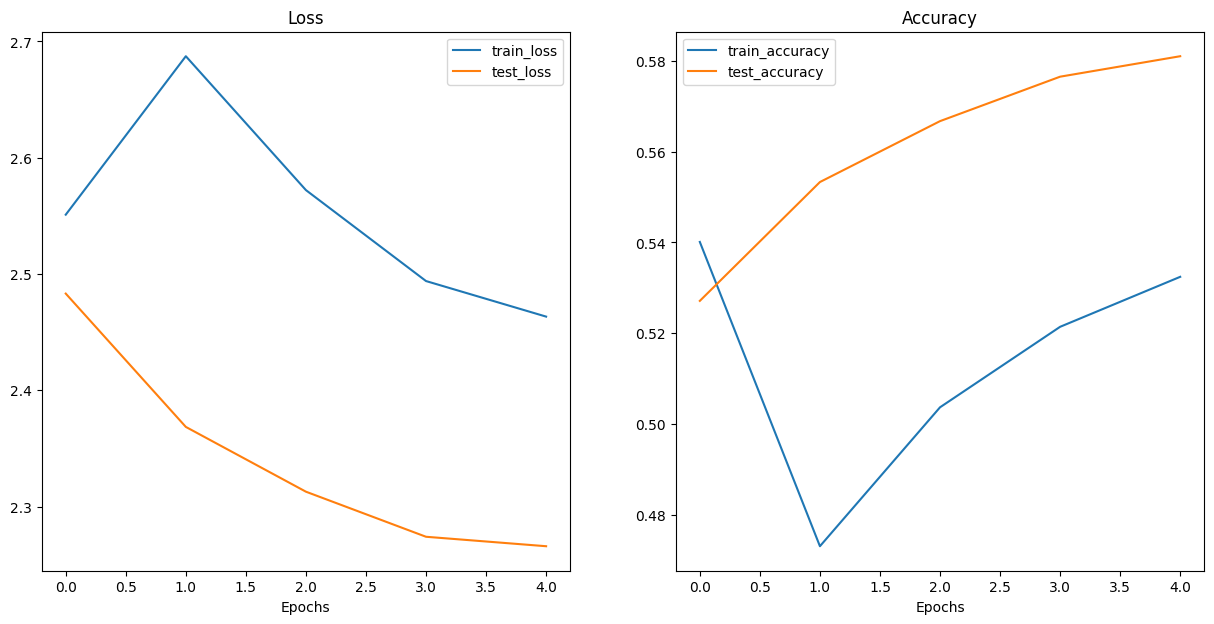

In [97]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load FoodVision Big model

In [98]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [99]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's stat_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

In [100]:
from pathlib import PurePath

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path('models', effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


### 11. Turning our FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world (the ultimate test set).

Let's create an outline for our FoodVision Big app:
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```


In [101]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path('demos/foodvision_big/')

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True,
                                              exist_ok=True)

In [102]:
!ls demos/foodvision_big/

examples


In [109]:
download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/ribeye-steak.jpg",
    path="steak", name="steak.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/sushi.jpeg",
    path="sushi", name="sushi.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/shayan-ramesht-exSEmuA7R7k-unsplash.jpg",
    path="pizza", name="custom_pizza2.jpeg")

download_custom_img(github_path="https://raw.githubusercontent.com/AishaEvering/PyTorch_Exercises/main/assests/charlesdeluvio-3bhnI1Am5Yc-unsplash.jpg",
    path="ice_cream", name="ice_cream.jpeg")

data/custom_images/steak directory exists, skipping re-download.
data/custom_images/steak/steak.jpeg already exists, skipping download...
data/custom_images/sushi directory exists, skipping re-download.
data/custom_images/sushi/sushi.jpeg already exists, skipping download...
data/custom_images/pizza directory exists, skipping re-download.
data/custom_images/pizza/custom_pizza2.jpeg already exists, skipping download...
data/custom_images/ice_cream directory exists, skipping re-download.
data/custom_images/ice_cream/ice_cream.jpeg already exists, skipping download...


In [110]:
data_path = Path('data')
custom_img_path = data_path / "custom_images"

# Collect three random test dataset image paths
custom_paths = [
    custom_img_path / 'pizza/custom_pizza2.jpeg',
    custom_img_path / 'steak/steak.jpeg',
    custom_img_path / 'sushi/sushi.jpeg',
    custom_img_path / 'ice_cream/ice_cream.jpeg',
]

custom_paths

[PosixPath('data/custom_images/pizza/custom_pizza2.jpeg'),
 PosixPath('data/custom_images/steak/steak.jpeg'),
 PosixPath('data/custom_images/sushi/sushi.jpeg'),
 PosixPath('data/custom_images/ice_cream/ice_cream.jpeg')]

In [112]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_big_examples_path = foodvision_big_demo_path / 'examples'
foodvision_big_examples_path.mkdir(parents=True, exist_ok=True)

# Copy the three images to the examples directory
for example in custom_paths:
  destination = foodvision_big_examples_path / example.name
  print(f'[INFO] Copying {example} to {destination}')
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/custom_images/pizza/custom_pizza2.jpeg to demos/foodvision_big/examples/custom_pizza2.jpeg
[INFO] Copying data/custom_images/steak/steak.jpeg to demos/foodvision_big/examples/steak.jpeg
[INFO] Copying data/custom_images/sushi/sushi.jpeg to demos/foodvision_big/examples/sushi.jpeg
[INFO] Copying data/custom_images/ice_cream/ice_cream.jpeg to demos/foodvision_big/examples/ice_cream.jpeg


In [113]:
import os

# Get example filepaths in a list of lists
example_list = [['examples/' + example] for example in os.listdir(foodvision_big_examples_path)]
example_list

[['examples/.ipynb_checkpoints'],
 ['examples/sushi.jpeg'],
 ['examples/steak.jpeg'],
 ['examples/custom_pizza2.jpeg'],
 ['examples/ice_cream.jpeg']]

In [114]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big/

### 11.2 Savign Food101 class names to file (`class_names.txt`)

Let's save all of the Food101 class names to a .txt file so we can import them use them in our app.

In [116]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [118]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [119]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, 'w') as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [124]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  foodvision_big_class_names_loaded = [food.strip() for food in f.readlines()]

foodvision_big_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (model.py)

In [125]:
%%writefile demos/foodvision_big/model.py

import torch
import torchvision
import torchvision.models.efficientnet
import torchvision.transforms
from torch import nn

def create_effnetb2_model(num_classes: int = 3,  # default output classes = 3 (pizza, steak, sushi)
                          seed: int = 42) -> tuple[torchvision.models.efficientnet.EfficientNet, torchvision.transforms.Compose]:

    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze base layers in the model (this will stop all layers from training)
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script ('app.py')

The `app.py` file will have 4 major parts:
1. Imports and class names setup - for class names, we'll need to import from `class_names.txt` rather than with Python list
2. Model and transforms preparation - we'll need to make sure our model is suitable for FoodVision Big
3. Predict function (`predict()`) - this can stay the same as the original `predict()`
4. Gradio app - our Gradio interface + launch command - this will change slightly from FoodVision Mini to reflect the FoodVision Big updates

In [126]:
%%writefile demos/foodvision_big/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

# setup class names
with open('class_names.txt', 'r') as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

# model and transforms prep
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# load saved weights
effnetb2.load_state_dict(
    torch.load(
        f='09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth',
        map_location=torch.device('cpu') #load the model to the cpu
    )
)

# predict function
def predict(img) -> tuple[dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)


  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  pred_time = round(timer() - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

  import gradio as gr

# Create example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

# Gradio app demo

# Create title, description and article
title = 'FoodVision BIG 🥗 👀'
description = 'An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify [101 classes of food from the Food101 dataset](https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/food101_class_names.txt).'
article = 'Created at [09. PyTorch Model Deployment](https://github.com/AishaEvering/PyTorch_Exercises/blob/main/09_pytorch_model_deploy.ipynb).'

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (seconds)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!!!!
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)

In [127]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.3.1
torchvision==0.18.1
gradio==4.36.1

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big files

In [129]:
# Change into the foodvision_big directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/sushi.jpeg (deflated 5%)
  adding: examples/steak.jpeg (deflated 0%)
  adding: examples/custom_pizza2.jpeg (deflated 1%)
  adding: examples/ice_cream.jpeg (deflated 1%)
  adding: model.py (deflated 52%)
  adding: requirements.txt (deflated 6%)


In [130]:
# Download
try:
  from google.colab import files
  files.download('demos/foodvision_big.zip')
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), \
  please download foodvision_big.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying our FoodVision Big model app to Hugging Face Spaces

Let's bring FoodVision Big to life by deploying it to the world!!!

See our deployed app here: https://huggingface.co/spaces/AishaE/foodvision_big